In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from utils import data_utils as du, feature_utils as fu, plot_utils as pu

# Load Data

In [2]:
exchange = "binance"

start_date = "20230101"
end_date = "20241231"

start_dt = dt.datetime.strptime(start_date, "%Y%m%d")
end_dt = dt.datetime.strptime(end_date, "%Y%m%d")

In [3]:
level1_data = du.get_files(start_dt, end_dt, "level1", exchange, "futures", "BTCUSDT")
book_data = du.get_files(start_dt, end_dt, "book", exchange, "futures", "BTCUSDT")
trade_data = du.get_files(start_dt, end_dt, "trade", exchange, "futures", "BTCUSDT")

level1_data.shape, book_data.shape, trade_data.shape

((1052640, 28), (1052640, 63), (1052640, 23))

In [4]:
# Convert timestamps to datetime
level1_data['ts_end'] = pd.to_datetime(level1_data['ts_end'], unit='ms')
book_data[['ts_end', 'ts_book']] = book_data[['ts_end', 'ts_book']].apply(pd.to_datetime, unit='ms')
trade_data['ts_end'] = pd.to_datetime(trade_data['ts_end'], unit='ms')

# Set index to ts_end
level1_data.set_index('ts_end', inplace=True)
book_data.set_index('ts_end', inplace=True)
trade_data.set_index('ts_end', inplace=True)

# Align time series data
(level1_data, book_data, trade_data), start, end = du.align_ts(level1_data, book_data, trade_data)

# Create a common time index
time_idx = pd.date_range(start=start, end=end, freq='1min')

time_idx[[0, -1]]

DatetimeIndex(['2023-01-01 00:01:00', '2024-12-31 23:59:00'], dtype='datetime64[ns]', freq=None)

In [5]:
# Compute log return
level1_data['log_return'] = np.log(level1_data['close_mid'] / level1_data['close_mid'].shift(1))

#### Level1 Features

In [6]:
taus = [1, 5, 15, 30, 60]
feature_level1_df = fu.feature_level1(time_idx, level1_data, taus)
feature_level1_df.tail()

,log_ret_1m,log_ret_5m,log_ret_15m,log_ret_30m,log_ret_60m,abs_ret_1m,abs_ret_5m,abs_ret_15m,abs_ret_30m,abs_ret_60m,...,spread_mean,spread_median,spread_min,spread_max,spread_mean_norm,spread_median_norm,spread_min_norm,spread_max_norm,log_spread_mean_norm,log_spread_median_norm
2024-12-31 23:55:00,-0.000195,0.001075,0.001974,0.000179,0.001293,0.000195,0.001075,0.001974,0.000179,0.001293,...,0.533987,0.1,0.1,6.5,0.000006,0.000001,0.000001,0.000069,0.000006,0.000001
2024-12-31 23:56:00,0.000270,0.000669,0.002396,0.000500,0.001450,0.000270,0.000669,0.002396,0.000500,0.001450,...,0.577692,0.1,0.1,5.6,0.000006,0.000001,0.000001,0.000060,0.000006,0.000001
2024-12-31 23:57:00,-0.000425,-0.000425,0.001477,-0.000932,0.001668,0.000425,0.000425,0.001477,0.000932,0.001668,...,0.612829,0.2,0.1,11.5,0.000007,0.000002,0.000001,0.000123,0.000007,0.000002
2024-12-31 23:58:00,-0.000265,-0.000940,0.001383,-0.001241,0.001598,0.000265,0.000940,0.001383,0.001241,0.001598,...,0.483636,0.1,0.1,3.3,0.000005,0.000001,0.000001,0.000035,0.000005,0.000001
2024-12-31 23:59:00,-0.000155,-0.000770,0.001436,-0.001345,0.001532,0.000155,0.000770,0.001436,0.001345,0.001532,...,0.736752,0.1,0.1,12.8,0.000008,0.000001,0.000001,0.000137,0.000008,0.000001


#### Book Features

In [7]:
feature_book_df = fu.feature_book(time_idx, book_data)
feature_book_df.tail()

,obi,obi_1bps,obi_3bps,obi_10bps,obi_30bps,obi_100bps,ofi,ofi_1bps,ofi_3bps,ofi_10bps,ofi_30bps,ofi_100bps
2024-12-31 23:55:00,-0.033011,-0.739488,-0.343992,-0.093641,-0.042683,-0.042683,30.452055,-2.716439,0.371663,-18.270748,2.569667,2.569667
2024-12-31 23:56:00,-0.985821,-0.661873,-0.198578,-0.142965,-0.038889,-0.038889,0.293346,-0.804979,-0.807130,0.462147,-0.074233,-0.074233
2024-12-31 23:57:00,0.071460,0.055490,0.020008,0.045420,0.024329,0.024329,0.823500,-1.134595,-8.728578,-3.110297,3.375156,3.375156
2024-12-31 23:58:00,-0.598751,-0.570515,0.007376,0.096679,0.011856,0.011856,1.696266,-1.324837,0.332187,3.356803,0.299030,0.299030
2024-12-31 23:59:00,0.638357,0.665453,0.210867,0.286810,0.122075,0.122075,3.557957,-8.920767,8.799315,11.463836,-47.880911,-47.880911


#### Trade Features

In [8]:
taus = [1, 5, 15, 30, 60]
feature_trade_df = fu.feature_trade(time_idx, trade_data, taus)
feature_trade_df.tail()

,trade_vol,trade_count,trade_vol_ema_1m,trade_vol_ema_5m,trade_vol_ema_15m,trade_vol_ema_30m,trade_vol_ema_60m,buy_trade_count,sell_trade_count,taker_trade_count,...,buy_volume_ema_1m,buy_volume_ema_5m,buy_volume_ema_15m,buy_volume_ema_30m,buy_volume_ema_60m,sell_volume_ema_1m,sell_volume_ema_5m,sell_volume_ema_15m,sell_volume_ema_30m,sell_volume_ema_60m
2024-12-31 23:55:00,0.136762,777,0.136762,0.133570,0.137157,0.139700,0.143085,141,243,263,...,14.680,26.735441,27.840842,26.440307,26.360099,19.146,19.355794,20.635204,22.078277,23.708339
2024-12-31 23:56:00,0.079687,803,0.079687,0.115609,0.129974,0.135828,0.141007,246,112,261,...,52.699,35.389961,30.948112,28.134417,27.223669,12.842,17.184529,19.661054,21.482388,23.352065
2024-12-31 23:57:00,0.122685,1018,0.122685,0.117968,0.129063,0.134980,0.140406,210,350,326,...,8.748,26.509307,28.173098,26.883680,26.617909,16.032,16.800353,19.207422,21.130750,23.112063
2024-12-31 23:58:00,0.055708,661,0.055708,0.097215,0.119893,0.129866,0.137629,86,194,215,...,4.814,19.277538,25.253211,25.459830,25.903027,12.673,15.424569,18.390619,20.585089,22.769799
2024-12-31 23:59:00,0.159267,714,0.159267,0.117899,0.124815,0.131763,0.138338,84,234,224,...,5.755,14.770025,22.815934,24.188550,25.242436,12.175,14.341379,17.613667,20.042503,22.422428


#### Other Features

In [9]:
feature_others_df = fu.feature_others(time_idx)
feature_others_df.tail()

,hour,sin_hour,cos_hour,minute,sin_minute,cos_minute,day_of_week,sin_dow,cos_dow,is_weekend,is_dst,is_hour_start,is_hour_end
2024-12-31 23:55:00,23,-0.258819,0.965926,55,-0.500000,0.866025,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:56:00,23,-0.258819,0.965926,56,-0.406737,0.913545,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:57:00,23,-0.258819,0.965926,57,-0.309017,0.951057,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:58:00,23,-0.258819,0.965926,58,-0.207912,0.978148,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:59:00,23,-0.258819,0.965926,59,-0.104528,0.994522,1,0.781831,0.62349,0,0,0,1


# Target

In [10]:
target_rv_df = fu.target_rv(time_idx, level1_data, horizons=[60])
target_rv_df.head()

,target_rv_fwd60m
2023-01-01 00:01:00,0.158508
2023-01-01 00:02:00,0.158838
2023-01-01 00:03:00,0.159852
2023-01-01 00:04:00,0.157915
2023-01-01 00:05:00,0.158012


# Correlation

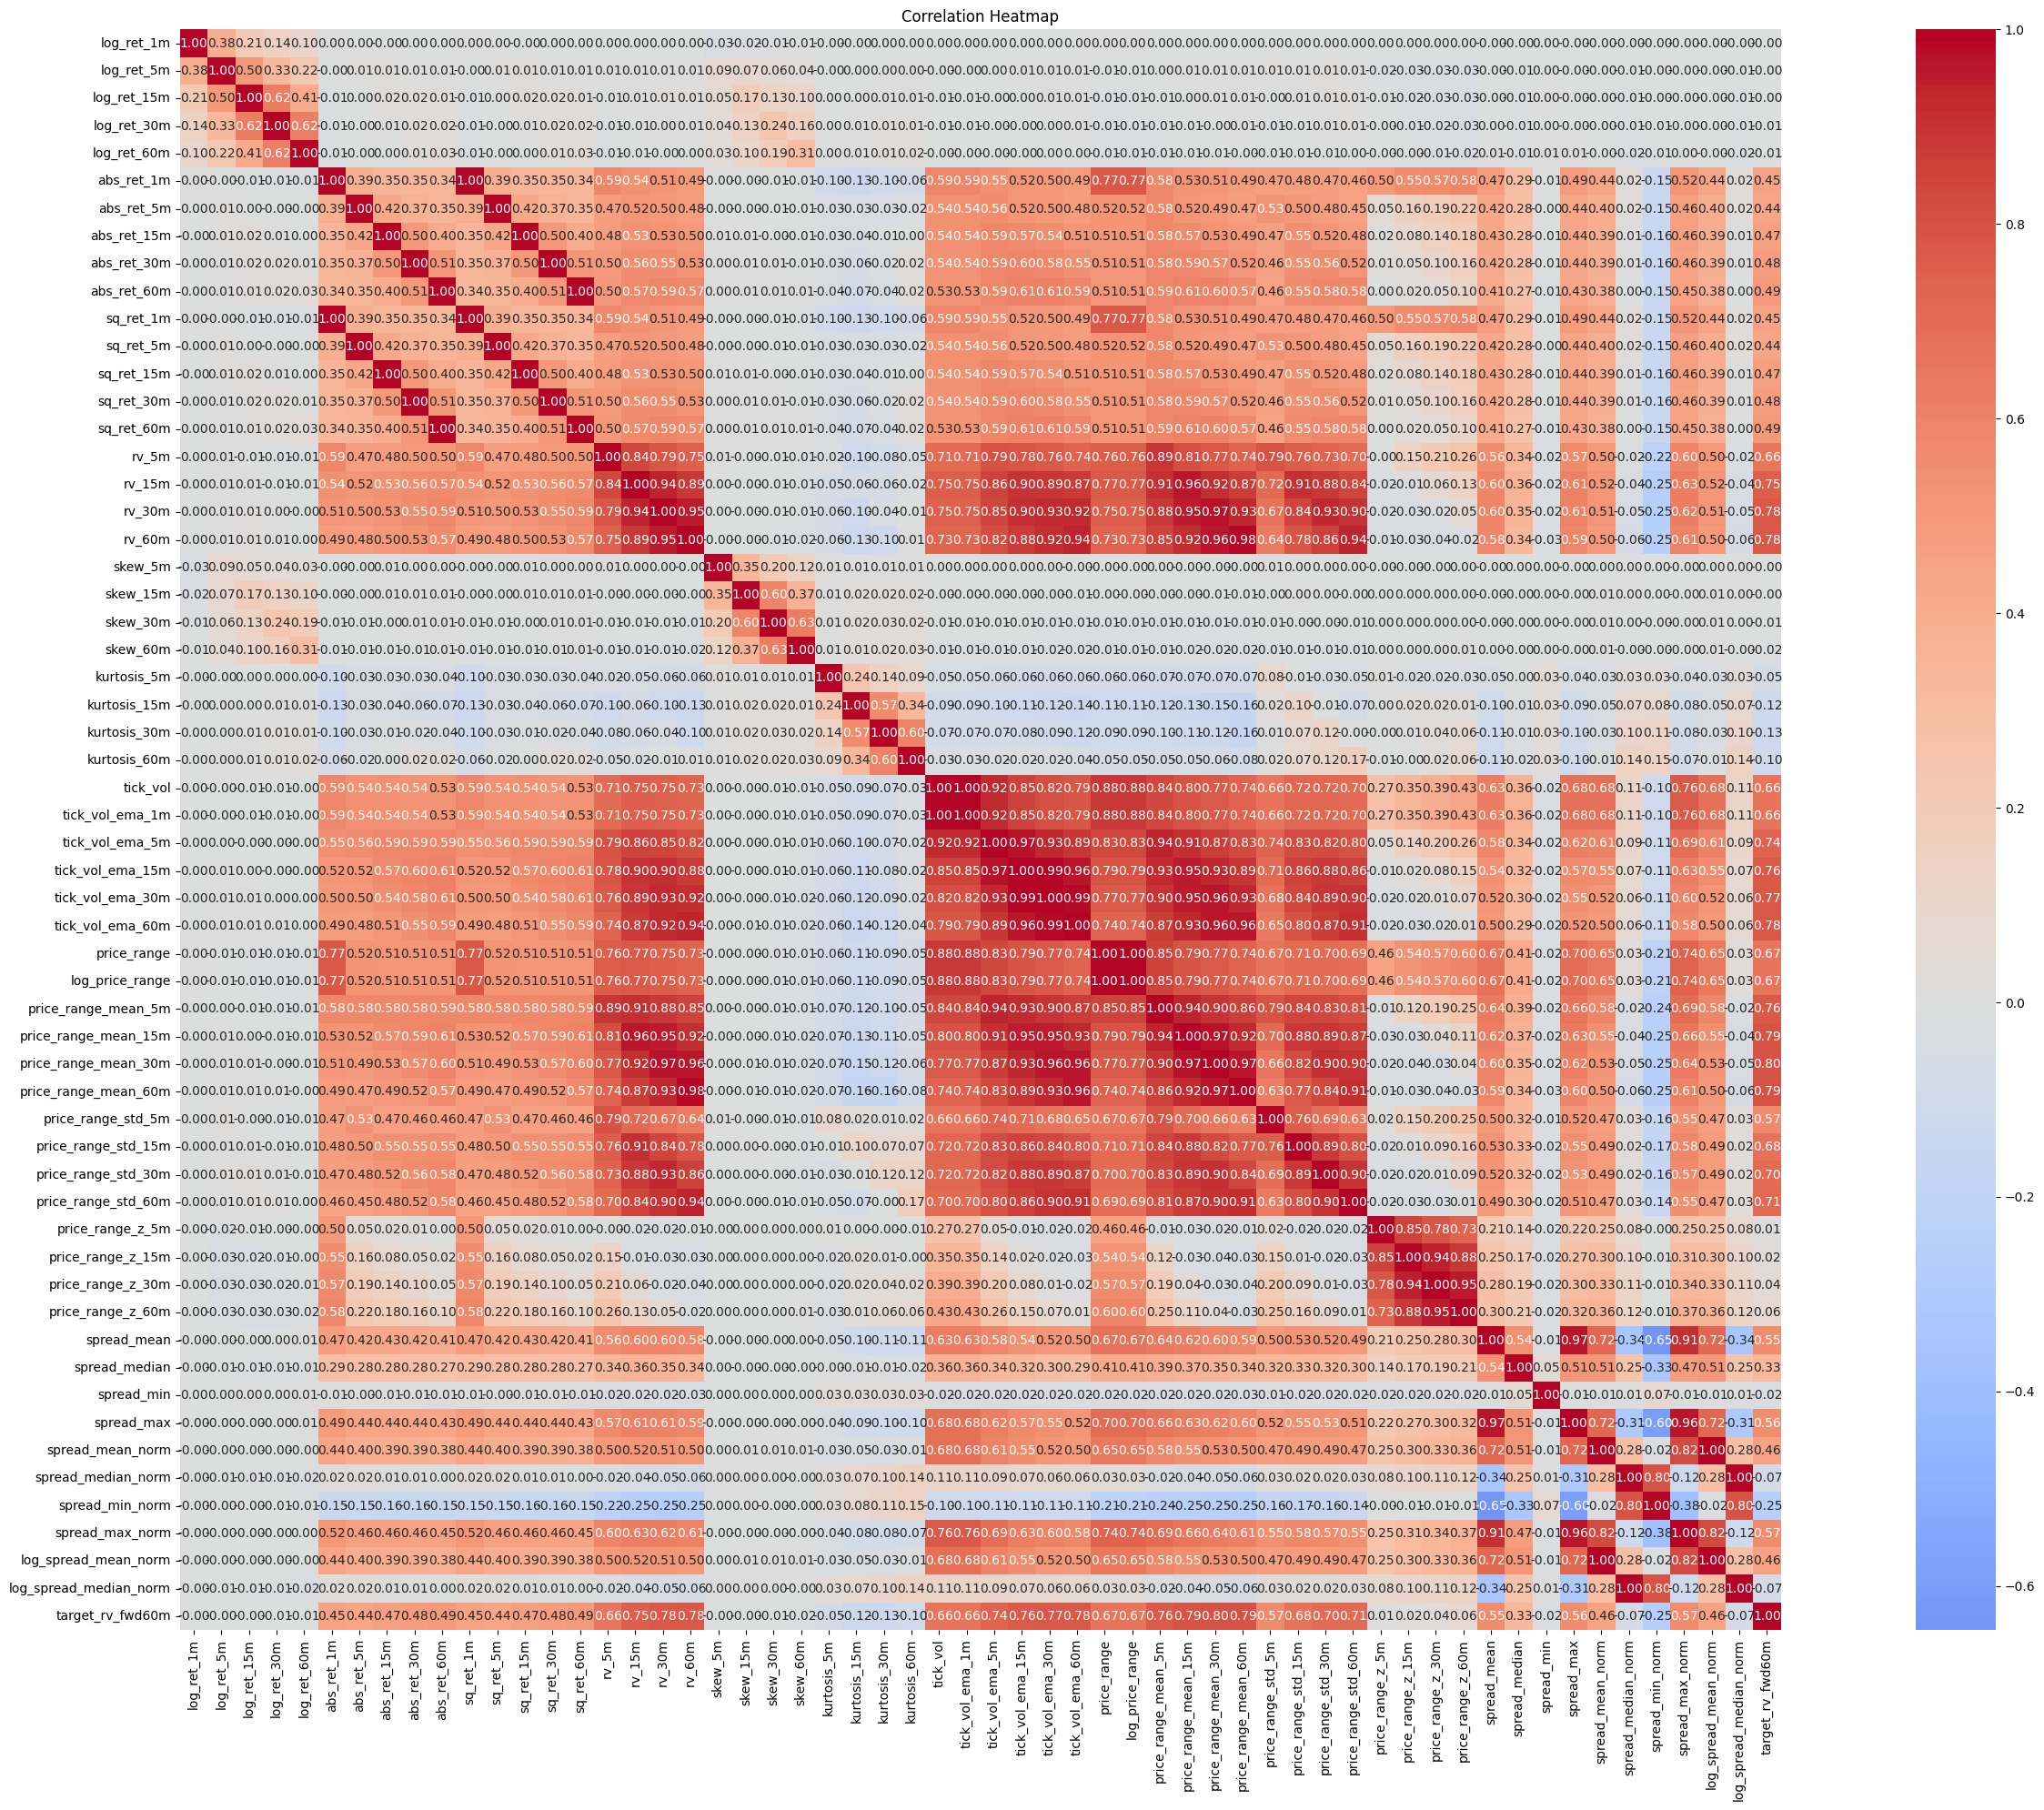

In [11]:
df_corr = pd.concat(
    [feature_level1_df, target_rv_df],
    axis=1
)

pu.plot_corr_heatmap(df_corr, figsize=(30,20))

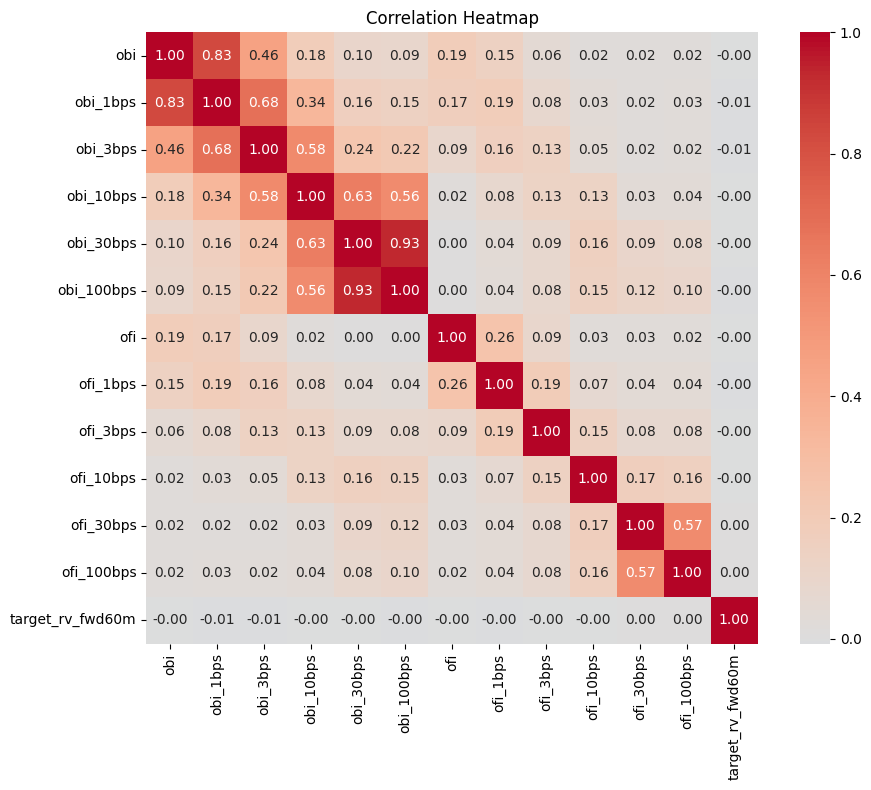

In [12]:
df_corr = pd.concat(
    [feature_book_df, target_rv_df],
    axis=1
)

pu.plot_corr_heatmap(df_corr)

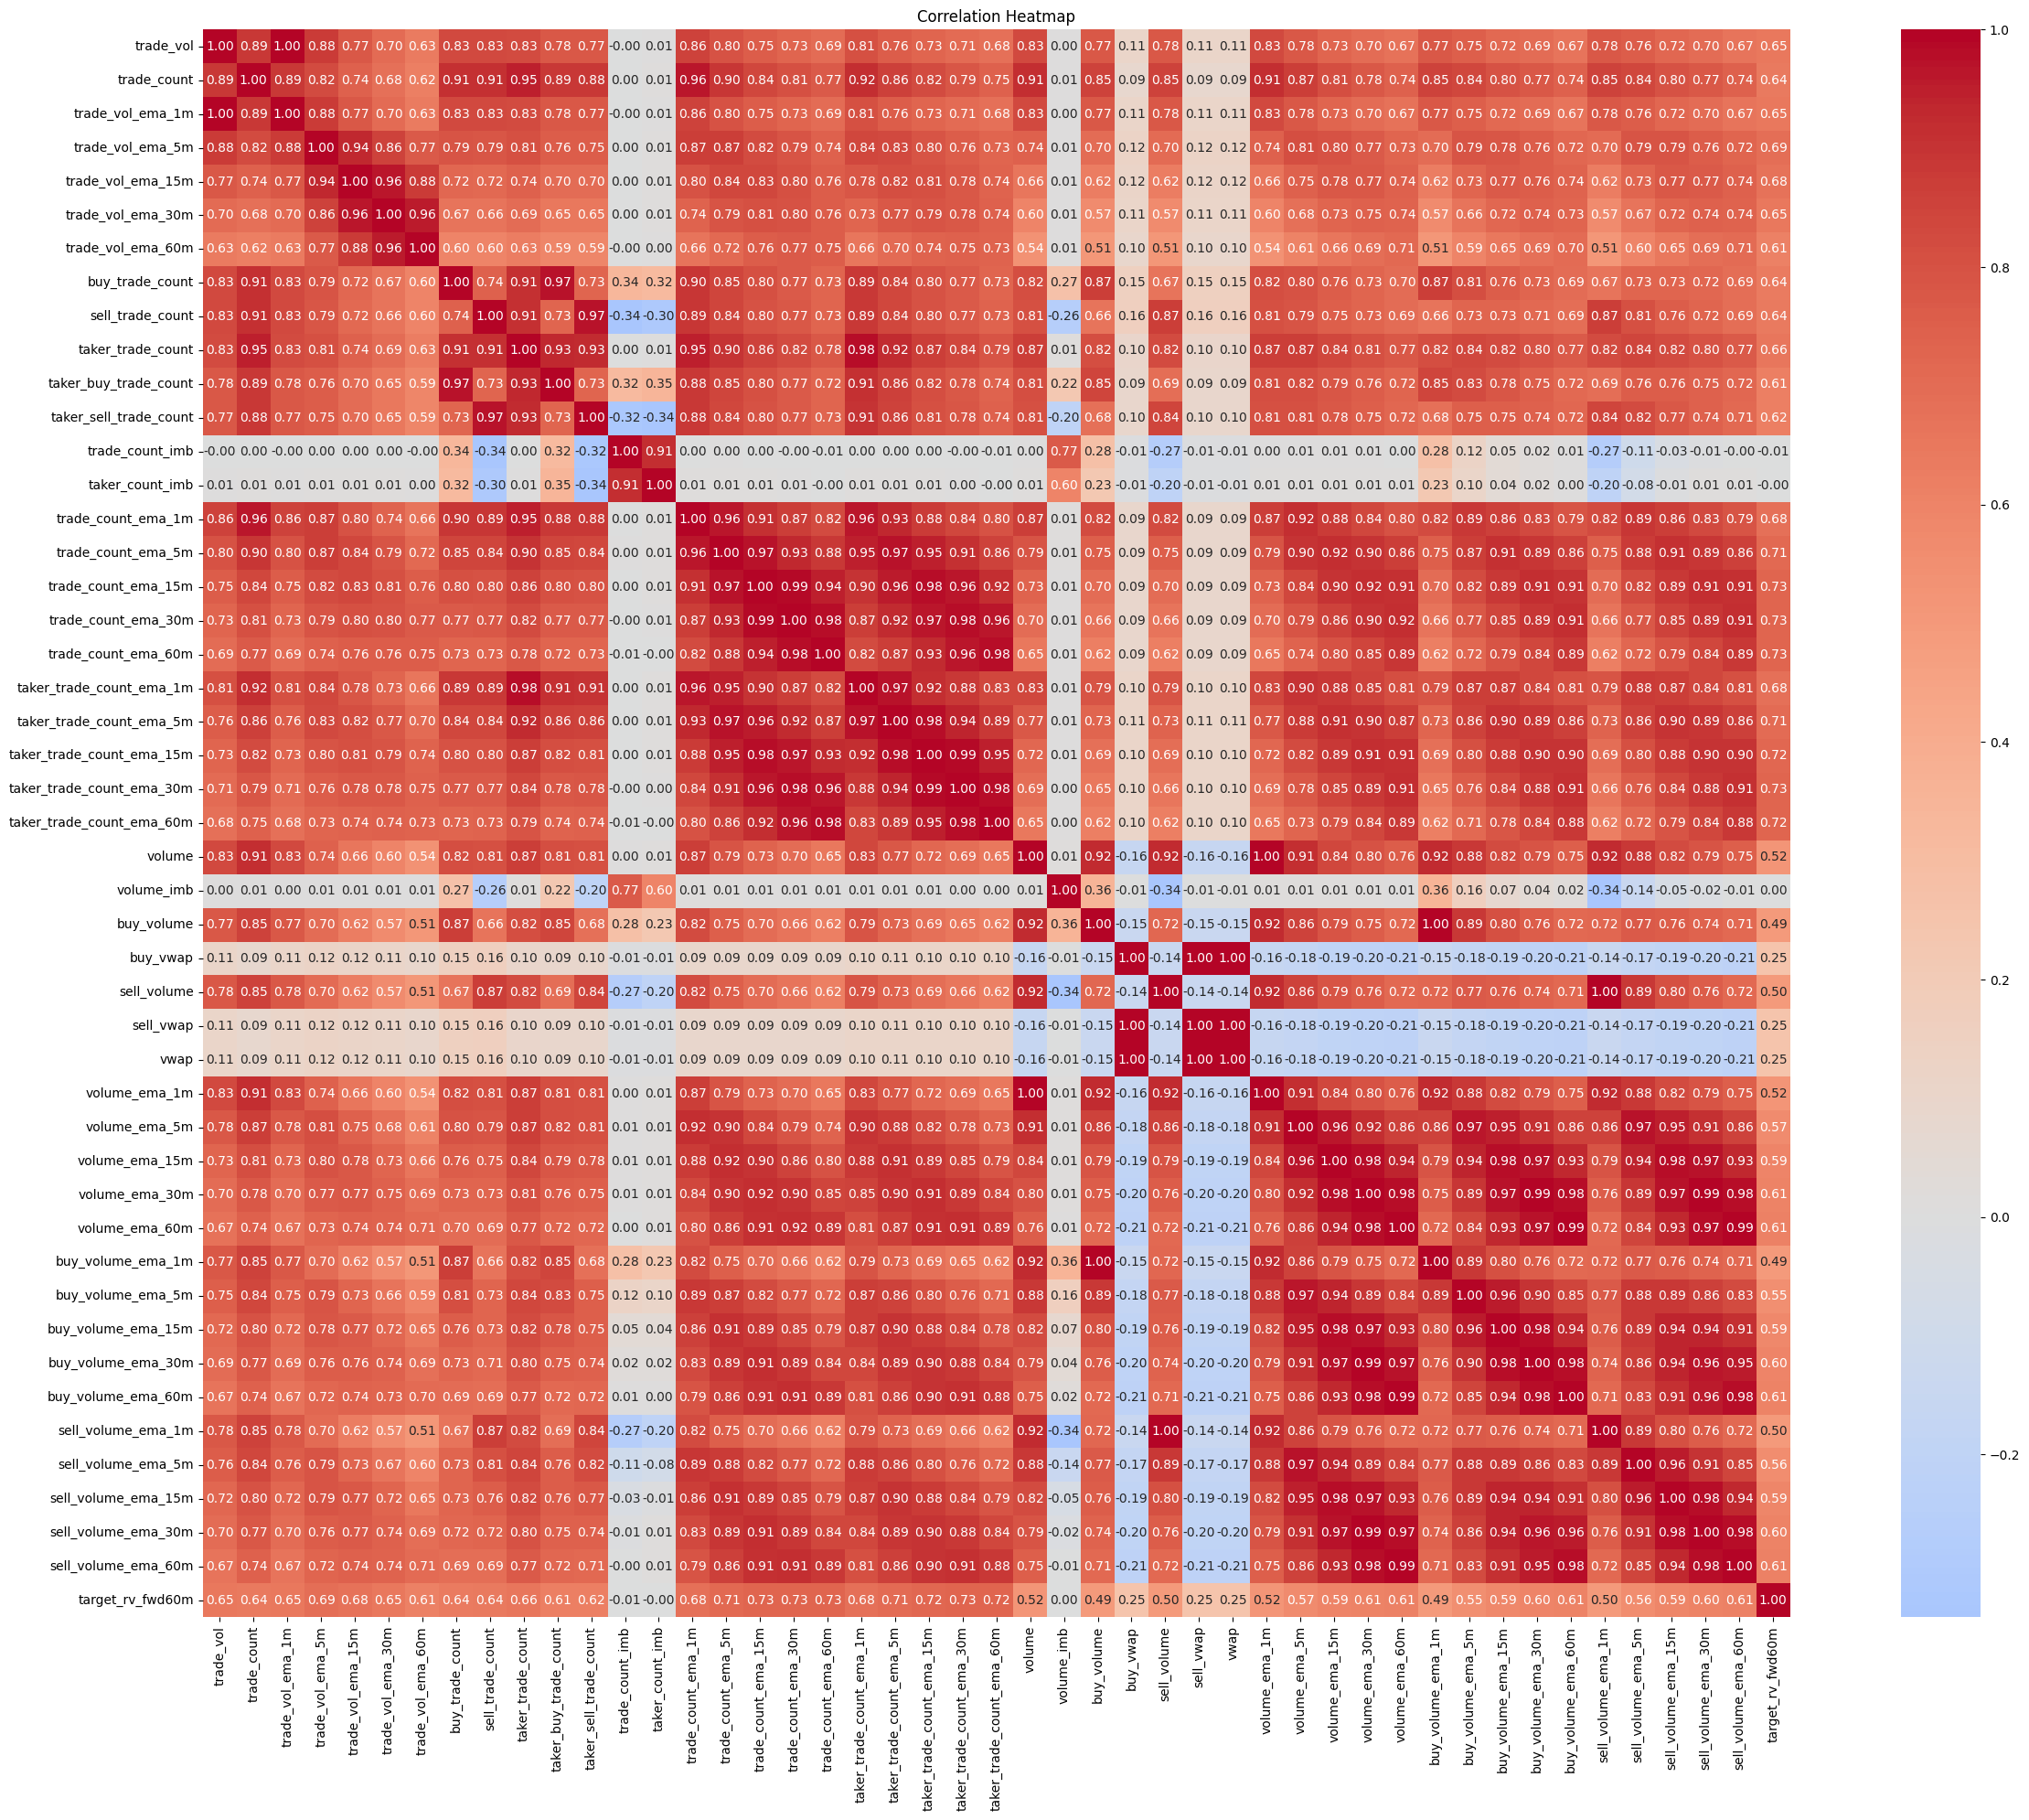

In [13]:
df_corr = pd.concat(
    [feature_trade_df, target_rv_df],
    axis=1
)

pu.plot_corr_heatmap(df_corr, figsize=(26,20))

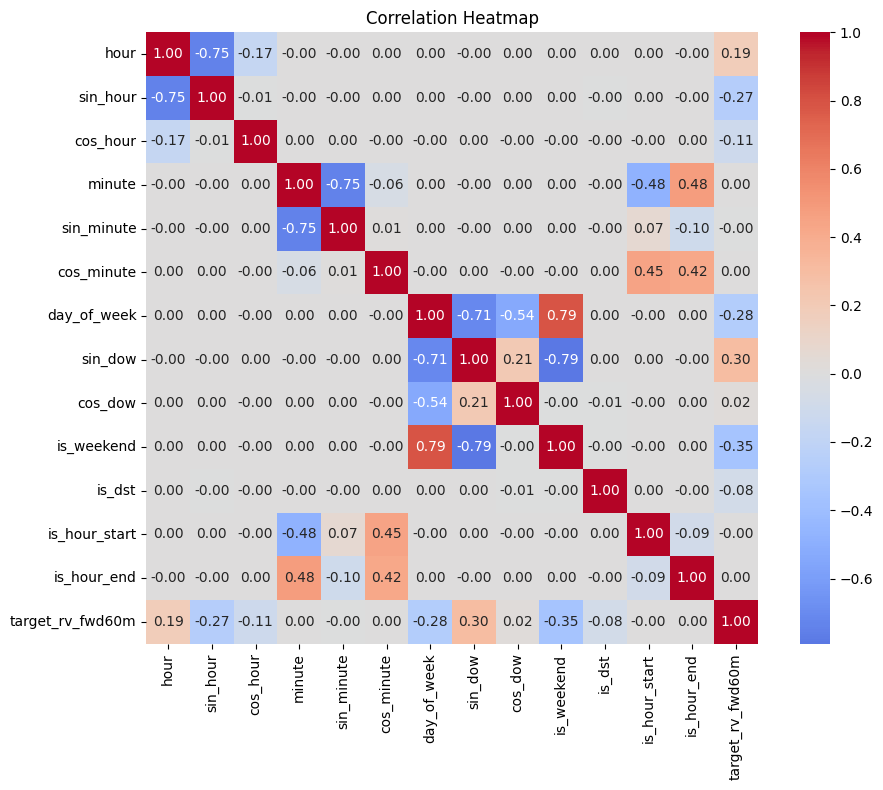

In [14]:
df_corr = pd.concat(
    [feature_others_df, target_rv_df],
    axis=1
)

pu.plot_corr_heatmap(df_corr)

---

# Features

In [ ]:
taus = [1, 5, 15, 30, 60]
features = fu.build_features(time_idx, level1_data, book_data, trade_data, taus)
features.tail()

In [ ]:
features.dropna(axis=0)

In [ ]:
ic = features.apply(lambda x: x.corr(target_rv_df["target_rv_fwd60m"], method="spearman"))

In [ ]:
good_features = ic[ic.abs() >= 0.10].index.tolist()

In [ ]:
corr = features[good_features].corr().abs()

kept = []
dropped = set()

for col in corr.columns:
    if col in dropped:
        continue
    kept.append(col)
    redundant = corr.index[corr[col] > 0.70].tolist()
    for r in redundant:
        if r != col:
            dropped.add(r)


In [ ]:
len(kept)

In [ ]:
kept

In [ ]:
final_ic = features[kept].apply(lambda x: x.corr(target_rv_df["target_rv_fwd60m"], method="spearman"))
print(final_ic.sort_values(ascending=False))

In [ ]:
X = features[kept]        # your 21 features
y = target_rv_df["target_rv_fwd60m"]

split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [ ]:
# Combine X and y for aligned cleaning
df_tmp = pd.concat([X, y], axis=1)

# Drop all rows with NaN
df_tmp = df_tmp.dropna()

# Split clean data
X = df_tmp[X.columns]
y = df_tmp[y.name]

split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [ ]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print("RMSE:", rmse)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

import scipy.stats as stats
ic = stats.spearmanr(y_pred, y_test).correlation
print("Spearman IC:", ic)

import matplotlib.pyplot as plt

plt.figure(figsize=(18,4))
plt.plot(y_test.values, label="Actual RV")
plt.plot(y_pred, label="Predicted RV")
plt.legend()
plt.title("Volatility Prediction — Simple Train/Test")
plt.show()


In [ ]:
import pandas as pd

importance = pd.Series(model.feature_importances_, index=X_train.columns)
print(importance.sort_values(ascending=False))


In [ ]:
import numpy as np
import lightgbm as lgb
import scipy.stats as stats

# ---------------------------
# 1. Walk-forward split helper
# ---------------------------
def walk_forward_splits(n, train_size, test_size):
    for start in range(0, n - train_size - test_size, test_size):
        train_idx = slice(start, start + train_size)
        test_idx  = slice(start + train_size, start + train_size + test_size)
        yield train_idx, test_idx


# ---------------------------
# 2. Feature selection (IC + corr)
# ---------------------------
def select_features(X_train, y_train, ic_thr=0.10, corr_thr=0.70):

    # IC filtering
    ic = X_train.apply(lambda x: x.corr(y_train, method="spearman"))
    good = ic[ic.abs() >= ic_thr].index.tolist()

    Xg = X_train[good]
    corr = Xg.corr().abs()

    kept = []
    dropped = set()

    for col in corr.columns:
        if col in dropped:
            continue
        kept.append(col)
        high_corr = corr.index[corr[col] > corr_thr].tolist()
        for hc in high_corr:
            if hc != col:
                dropped.add(hc)

    return kept


# ---------------------------
# 3. Full walk-forward pipeline
# ---------------------------
def run_wfcv(features, target, train_size, test_size,
             ic_thr=0.10, corr_thr=0.70):

    preds_all = []
    target_all = []

    n = len(features)

    for train_idx, test_idx in walk_forward_splits(n, train_size, test_size):

        X_train = features.iloc[train_idx]
        y_train = target.iloc[train_idx]

        X_test  = features.iloc[test_idx]
        y_test  = target.iloc[test_idx]

        # ---- Feature selection inside each fold ----
        kept = select_features(X_train, y_train, ic_thr, corr_thr)

        # ---- Fit LightGBM ----
        model = lgb.LGBMRegressor(
            n_estimators=300,
            learning_rate=0.05,
            num_leaves=63,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42
        )

        model.fit(X_train[kept], y_train)

        # ---- Predict ----
        preds = model.predict(X_test[kept])

        preds_all.append(preds)
        target_all.append(y_test.values)

    # concatenate all folds
    preds_all = np.concatenate(preds_all)
    target_all = np.concatenate(target_all)

    return preds_all, target_all


In [ ]:
preds, actual = run_wfcv(
    features=features[kept],   # or the full 128 features
    target=target_rv_df["target_rv_fwd60m"],
    train_size=100000,
    test_size=10000,
    ic_thr=0.10,
    corr_thr=0.70
)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(actual, preds))
mae  = mean_absolute_error(actual, preds)
ic   = stats.spearmanr(preds, actual).correlation

print("OOS RMSE:", rmse)
print("OOS MAE :", mae)
print("OOS IC  :", ic)

import matplotlib.pyplot as plt

plt.figure(figsize=(18,4))
plt.plot(actual, label="Actual RV", alpha=0.7)
plt.plot(preds, label="Predicted RV", alpha=0.7)
plt.legend()
plt.title("Walk-Forward OOS Volatility Forecast")
plt.show()


# Backtest

In [ ]:
import pandas as pd
import numpy as np

# preds: your OOS predicted RV (array-like)
# actual: target RV (not needed for backtest)
# returns: 1-minute log returns aligned with preds

df = pd.DataFrame({
    "pred_rv": preds,
    "ret": level1_data['log_return'][:len(preds)]  # align sizes
})


In [ ]:
df["pred_vol"] = np.sqrt(df["pred_rv"].clip(lower=1e-8))


In [ ]:
target_annual_vol = 0.20
minutes_per_year = 365 * 24 * 60
scale = target_annual_vol / np.sqrt(minutes_per_year)

df["weight"] = scale / df["pred_vol"]
df["weight"] = df["weight"].clip(-5, 5)  # optional cap


In [ ]:
df["strategy_ret"] = df["weight"] * df["ret"]


In [ ]:
df["cum_pnl"] = df["strategy_ret"].cumsum()

# Sharpe ratio (minute → annualized)
ann_factor = np.sqrt(minutes_per_year)

sharpe = df["strategy_ret"].mean() / df["strategy_ret"].std() * ann_factor

print("Sharpe:", sharpe)
print("Total Return:", df["cum_pnl"].iloc[-1])


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,4))
plt.plot(df["cum_pnl"], label="Vol-Managed Strategy")
plt.title("Volatility-Managed Strategy PnL")
plt.legend()
plt.show()


In [ ]:
df["btc_cum"] = df["ret"].cumsum()

import matplotlib.pyplot as plt

plt.figure(figsize=(18,4))

# plt.plot(df["cum_pnl"], label="Vol-Managed Strategy")
plt.plot(df["btc_cum"], label="BTC Buy & Hold", alpha=0.7)

# Optional baseline
# plt.plot(df["const_vol_cum"], label="Actual-Vol-Targeted", alpha=0.7)

plt.title("Volatility-Managed Strategy vs Baseline")
plt.legend()
plt.show()

